In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
from pathlib import Path

# Set up paths
NOTEBOOK_DIR = Path.cwd()
SRC_DIR = NOTEBOOK_DIR.parent / "src"
sys.path.append(str(SRC_DIR))

# Import the shared paths
from paths import (
    DATAFRAMES_DIR
)

In [2]:
df_teide = pd.read_parquet(DATAFRAMES_DIR / "df_teide_with_clusters.parquet")
df_roque = pd.read_parquet(DATAFRAMES_DIR / "df_roque_with_clusters.parquet")

In [3]:
def compare_cluster_frequencies(df_teide, df_roque, normalize=True):
    teide_counts = df_teide['cluster'].value_counts(normalize=normalize).sort_index()
    roque_counts = df_roque['cluster'].value_counts(normalize=normalize).sort_index()

    freq_df = pd.DataFrame({
        'Teide': teide_counts,
        'Roque': roque_counts
    })

    freq_df.plot(kind='bar', figsize=(8, 5), colormap='viridis')
    plt.title('Cluster Frequency Comparison')
    plt.xlabel('Cluster')
    plt.ylabel('Proportion' if normalize else 'Count')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

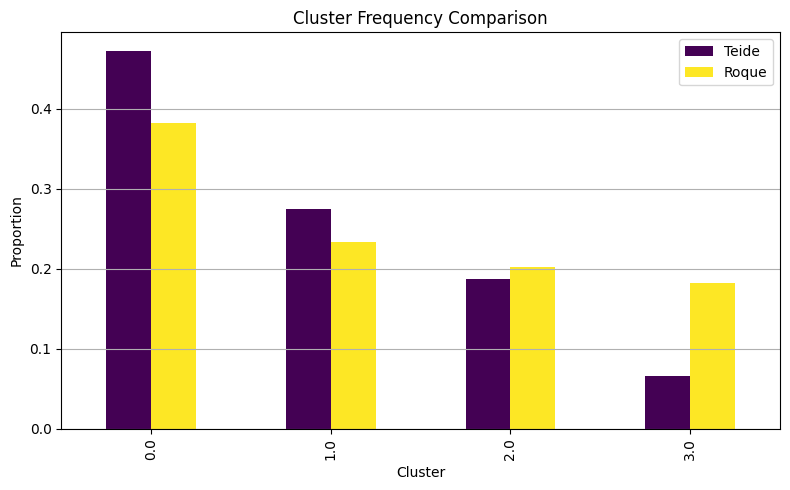

In [4]:
compare_cluster_frequencies(df_teide, df_roque)

In [5]:
# We can group by cluster and altitude, then calculate mean and std, to compose another plot

# Group by cluster and altitude, then calculate the mean and std
grouped_teide = df_teide.groupby(['cluster', 'altitude'])['turbulence_log'].agg(['mean', 'std']).reset_index()
# Same for Roque
grouped_roque = df_roque.groupby(['cluster', 'altitude'])['turbulence_log'].agg(['mean', 'std']).reset_index()

In [6]:
def plot_profile_shapes_per_cluster(grouped_teide, grouped_roque, site_teide='Teide', site_roque='Roque'):
    # Create a figure with two subplots side by side
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))  # Two subplots
    
    # Plot Teide site profile shapes
    for cluster in grouped_teide['cluster'].unique():
        cluster_data = grouped_teide[grouped_teide['cluster'] == cluster]
        ax[0].plot(cluster_data['mean'], cluster_data['altitude'], label=f'Cluster {cluster}', linewidth=2)
        ax[0].fill_betweenx(cluster_data['altitude'], 
                            cluster_data['mean'] - cluster_data['std'], 
                            cluster_data['mean'] + cluster_data['std'], 
                            alpha=0.3)
    
    # Plot Roque site profile shapes
    for cluster in grouped_roque['cluster'].unique():
        cluster_data = grouped_roque[grouped_roque['cluster'] == cluster]
        ax[1].plot(cluster_data['mean'], cluster_data['altitude'], label=f'Cluster {cluster}', linewidth=2)
        ax[1].fill_betweenx(cluster_data['altitude'], 
                            cluster_data['mean'] - cluster_data['std'], 
                            cluster_data['mean'] + cluster_data['std'], 
                            alpha=0.3)
    
    # Titles, labels, and legends
    ax[0].set_title(f'Mean Turbulence Profile for Each Cluster {site_teide}', fontsize=16)
    ax[1].set_title(f'Mean Turbulence Profile for Each Cluster {site_roque}', fontsize=16)
    
    for axis in ax:
        axis.set_ylabel('Altitude (m)', fontsize=12)
        axis.set_xlabel('Turbulence Value', fontsize=12)
        axis.grid(True)
        axis.legend()
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

#### Mean and ± standard deviation (representing the uncertainty or spread of the turbulence values)

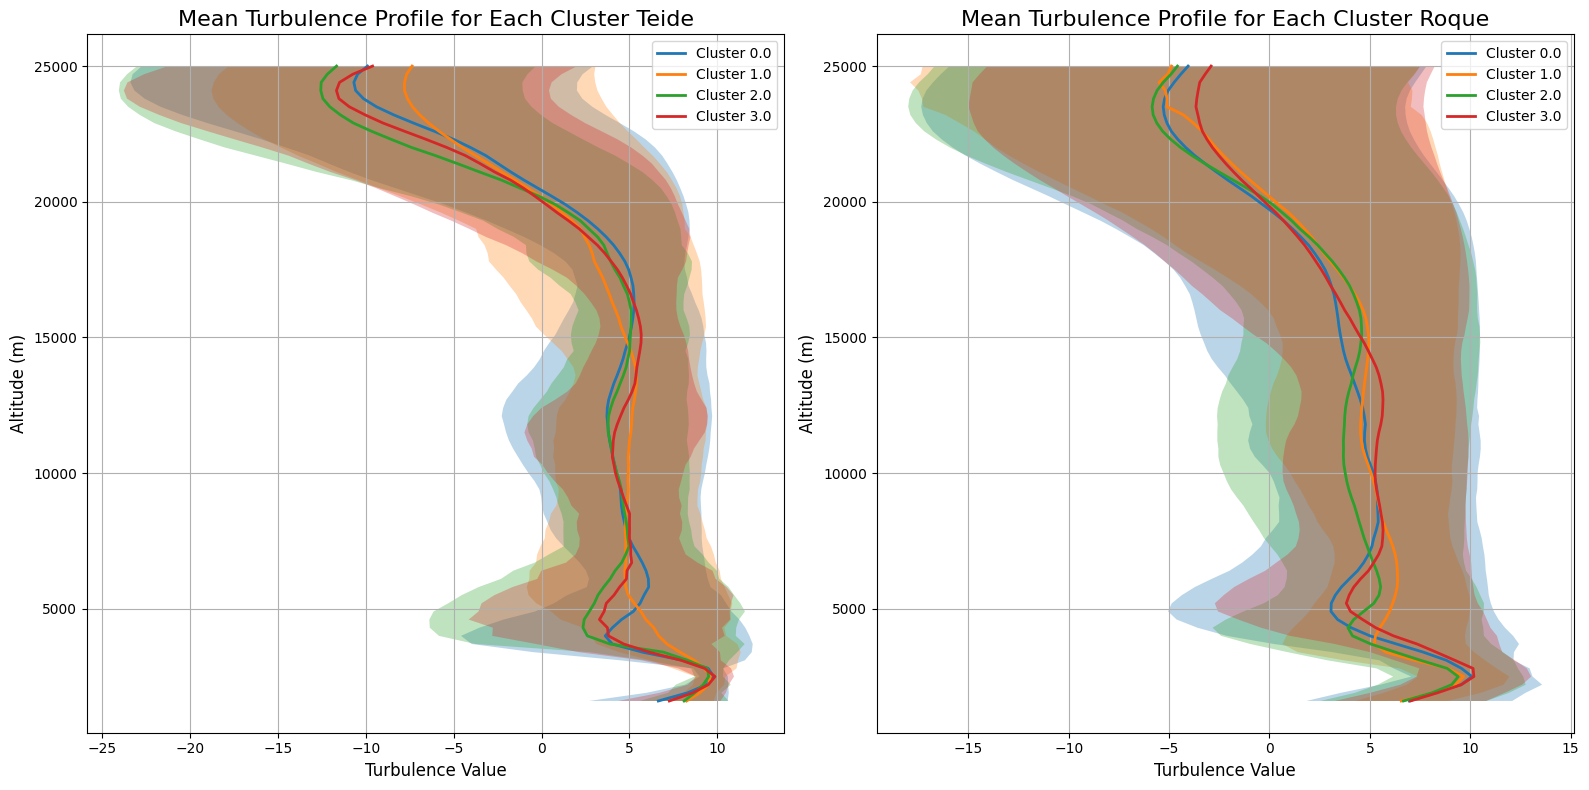

In [8]:
plot_profile_shapes_per_cluster(grouped_teide, grouped_roque)

In [9]:
def mean_turbulence_per_cluster(df, site):
    # Compute mean and std for each cluster at each altitude
    profile_stats = df.groupby(['cluster', 'altitude'])['turbulence_log'].agg(['mean', 'std']).reset_index()
    
    # Plot profiles, but dropna because of rows where there are no cluster value
    #This is a consequence of hourly profile_id group, since I filtered by if n_profiles < 2 ,no heatmap produced
    clusters = sorted(df['cluster'].dropna().unique())

    fig, axes = plt.subplots(1, len(clusters), figsize=(15, 5), sharey=True)
    
    # Store handles/labels for shared legend
    legend_handles = []
    legend_labels = []
    
    for i, c in enumerate(clusters):
        if np.isnan(c):
            continue
        cluster_data = profile_stats[profile_stats['cluster'] == c]
    
        ax = axes[i]
        line_mean, = ax.plot(cluster_data['mean'], cluster_data['altitude'], label='Mean Profile')
        fill_std = ax.fill_betweenx(cluster_data['altitude'],
                                    cluster_data['mean'] - cluster_data['std'],
                                    cluster_data['mean'] + cluster_data['std'],
                                    alpha=0.3, label='±1 std')
        
        if i == 0:
            ax.set_ylabel('Altitude (m)')
        ax.set_xlabel('Turbulence')
        ax.set_title(f'Cluster {c}')
        ax.grid(True)
        
        # Only collect legend items once
        if not legend_handles:
            legend_handles = [line_mean, fill_std]
            legend_labels = ['Mean Profile', '±1 std']
    
    # Add a single legend outside the subplots (right side)
    fig.legend(legend_handles, legend_labels, loc='center left', bbox_to_anchor=(1.02, 0.5))
    
    fig.suptitle(f'Mean Turbulence Profiles per Cluster {site}', fontsize=16)
    fig.tight_layout(rect=[0, 0, 0.85, 1])  # Leave space on right for legend
    plt.show()

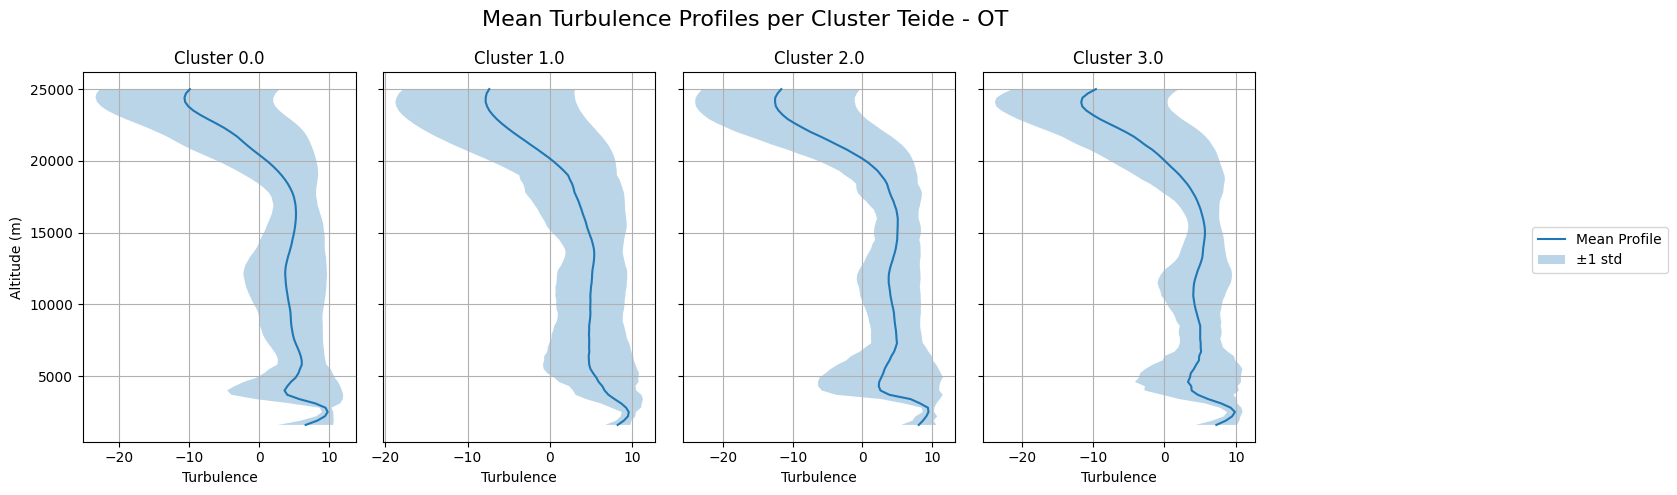

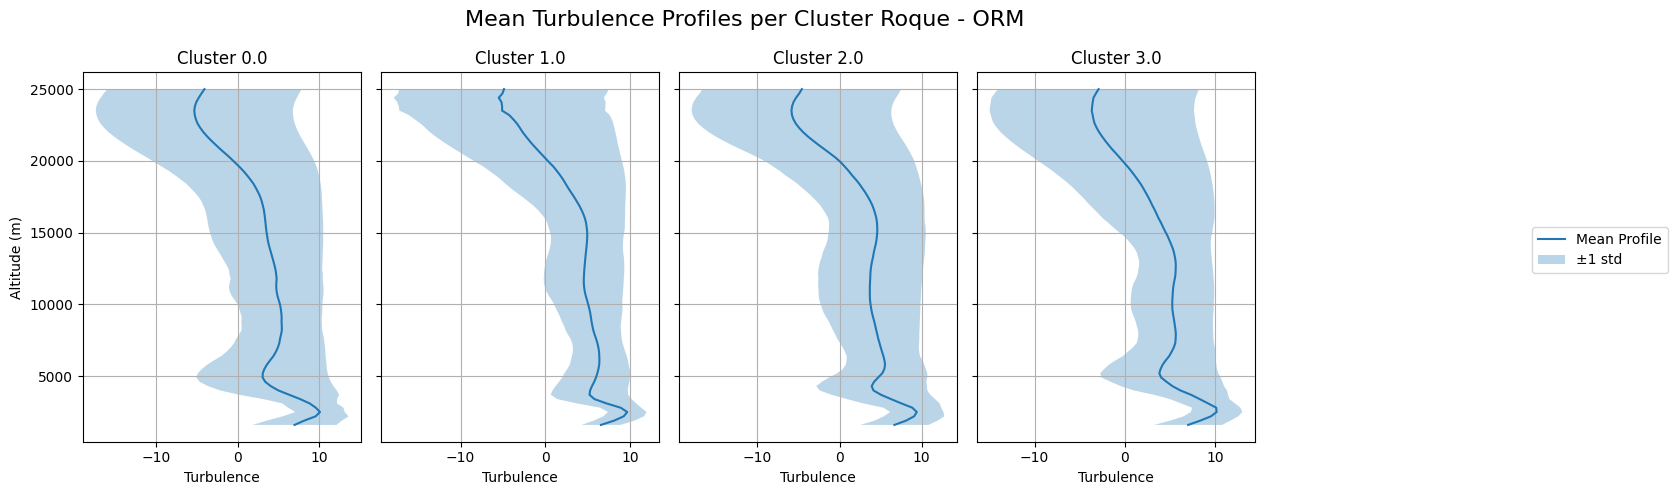

In [10]:
mean_turbulence_per_cluster(df_teide, 'Teide - OT')
mean_turbulence_per_cluster(df_roque, 'Roque - ORM')

In [11]:
def plot_cluster_temporal_distribution(df, site_name="Site"):
    """
    Plots hourly and seasonal (day-of-year) distributions of clusters in the given DataFrame.

    Parameters:
    - df: DataFrame with columns 'timestamp_begin' and 'cluster'
    - site_name: str, name for plot titles
    """

    # Ensure timestamp column is datetime
    df['timestamp_begin'] = pd.to_datetime(df['timestamp_begin'])

    # Extract hour and day-of-year
    df['hour'] = df['timestamp_begin'].dt.hour
    df['dayofyear'] = df['timestamp_begin'].dt.dayofyear

    # Function to get grouped and optionally normalized data
    def get_distributions(normalize):
        hourly = df.groupby(['hour', 'cluster']).size().unstack(fill_value=0)
        seasonal = df.groupby(['dayofyear', 'cluster']).size().unstack(fill_value=0)

        if normalize:
            hourly = hourly.div(hourly.sum(axis=1), axis=0)
            seasonal = seasonal.div(seasonal.sum(axis=1), axis=0)

        seasonal_smooth = seasonal.rolling(window=5, min_periods=1, center=True).mean()
        return hourly, seasonal_smooth

    # Get both normalized and raw data
    hourly_norm, seasonal_norm = get_distributions(normalize=True)
    hourly_raw, seasonal_raw = get_distributions(normalize=False)

    # --- Plotting ---
    fig, axs = plt.subplots(2, 2, figsize=(16, 10))

    # Top row - normalized (proportions)
    hourly_norm.plot(ax=axs[0, 0], kind='line', marker='o')
    axs[0, 0].set_title(f'Hourly Cluster Distribution (Proportion) - {site_name}')
    axs[0, 0].set_xlabel('Hour of Day')
    axs[0, 0].set_ylabel('Proportion')
    axs[0, 0].legend(title='Cluster')
    axs[0, 0].grid(True)

    seasonal_norm.plot(ax=axs[0, 1], kind='line', marker='o')
    axs[0, 1].set_title(f'Seasonal Cluster Distribution (Proportion) - {site_name}')
    axs[0, 1].set_xlabel('Day of Year')
    axs[0, 1].set_ylabel('Proportion')
    axs[0, 1].legend(title='Cluster')
    axs[0, 1].grid(True)

    # Bottom row - raw counts
    hourly_raw.plot(ax=axs[1, 0], kind='line', marker='o')
    axs[1, 0].set_title(f'Hourly Cluster Distribution (Count) - {site_name}')
    axs[1, 0].set_xlabel('Hour of Day')
    axs[1, 0].set_ylabel('Count')
    axs[1, 0].legend(title='Cluster')
    axs[1, 0].grid(True)

    seasonal_raw.plot(ax=axs[1, 1], kind='line', marker='o')
    axs[1, 1].set_title(f'Seasonal Cluster Distribution (Count) - {site_name}')
    axs[1, 1].set_xlabel('Day of Year')
    axs[1, 1].set_ylabel('Count')
    axs[1, 1].legend(title='Cluster')
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

#### ⏰  Hourly distribution (to detect daily cycles): i.e., what fraction of all measurements in that hour belong to each cluster.
#### 📌  Goal: Detect daily cycles, like “Cluster 2 tends to appear more around 6 AM”.



#### 📆 Seasonal/day-of-year distribution (to detect yearly patterns)
#### 📌 Goal: Detect seasonal patterns, like “Cluster 1 appears mostly during summer months”.

visualizing when (in time) each cluster tends to appear more often, across two temporal scales:

### 1. Proportion Plot
##### Proportions are normalized values ranging from 0 to 1. A point at zero means that the cluster did not appear on that particular day (or time period).
##### If a cluster has a proportion of 0 on a specific day, it simply means that, on that day, the cluster was not observed at all in the data.
##### Example: If the proportion of Cluster 1 is 0 on Day 50 of the year, this indicates that Cluster 1 was not present on Day 50. This does not imply that the cluster is irrelevant or absent entirely; it could just be inactive on that day.

### 2. Count Plot
##### Counts refer to the actual number of times a cluster appeared on a given day (or time period). A point at zero means that the cluster did not appear at all on that day.
#### If a cluster has zero count on a particular day, it indicates that, for that specific day, there were no profiles that belonged to that cluster.
#### Example: If Cluster 1 has a count of 0 on Day 50, it means that Cluster 1 had no profiles recorded on Day 50. This again doesn’t mean the cluster doesn't exist, but that on this specific day, it wasn't observed.

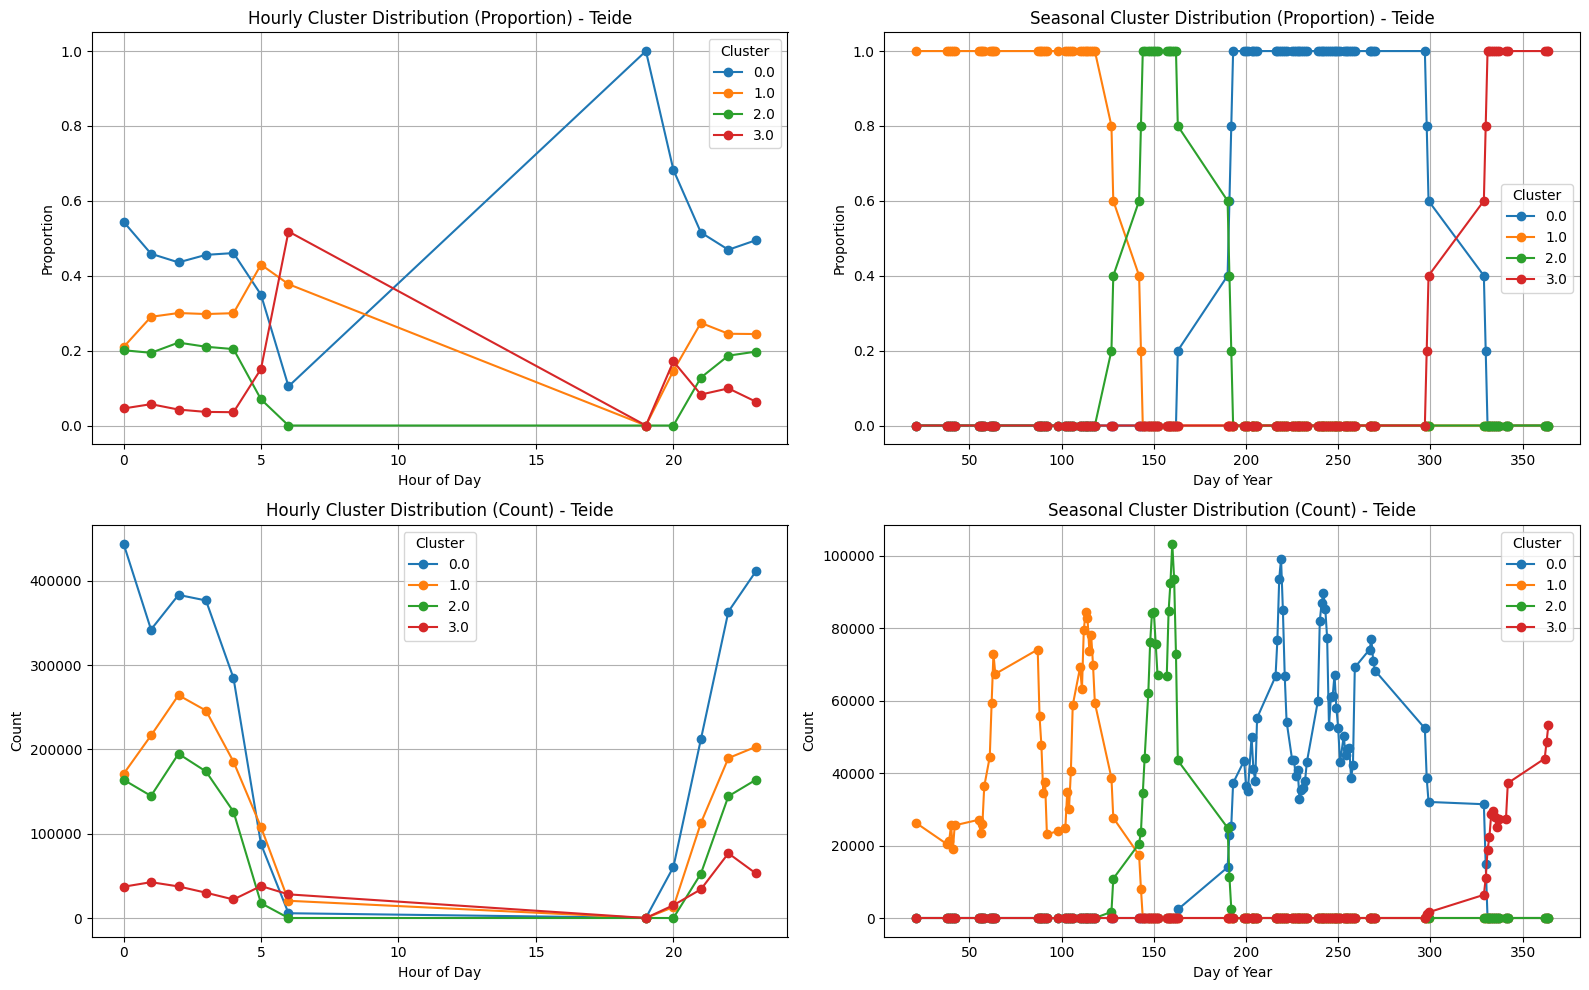

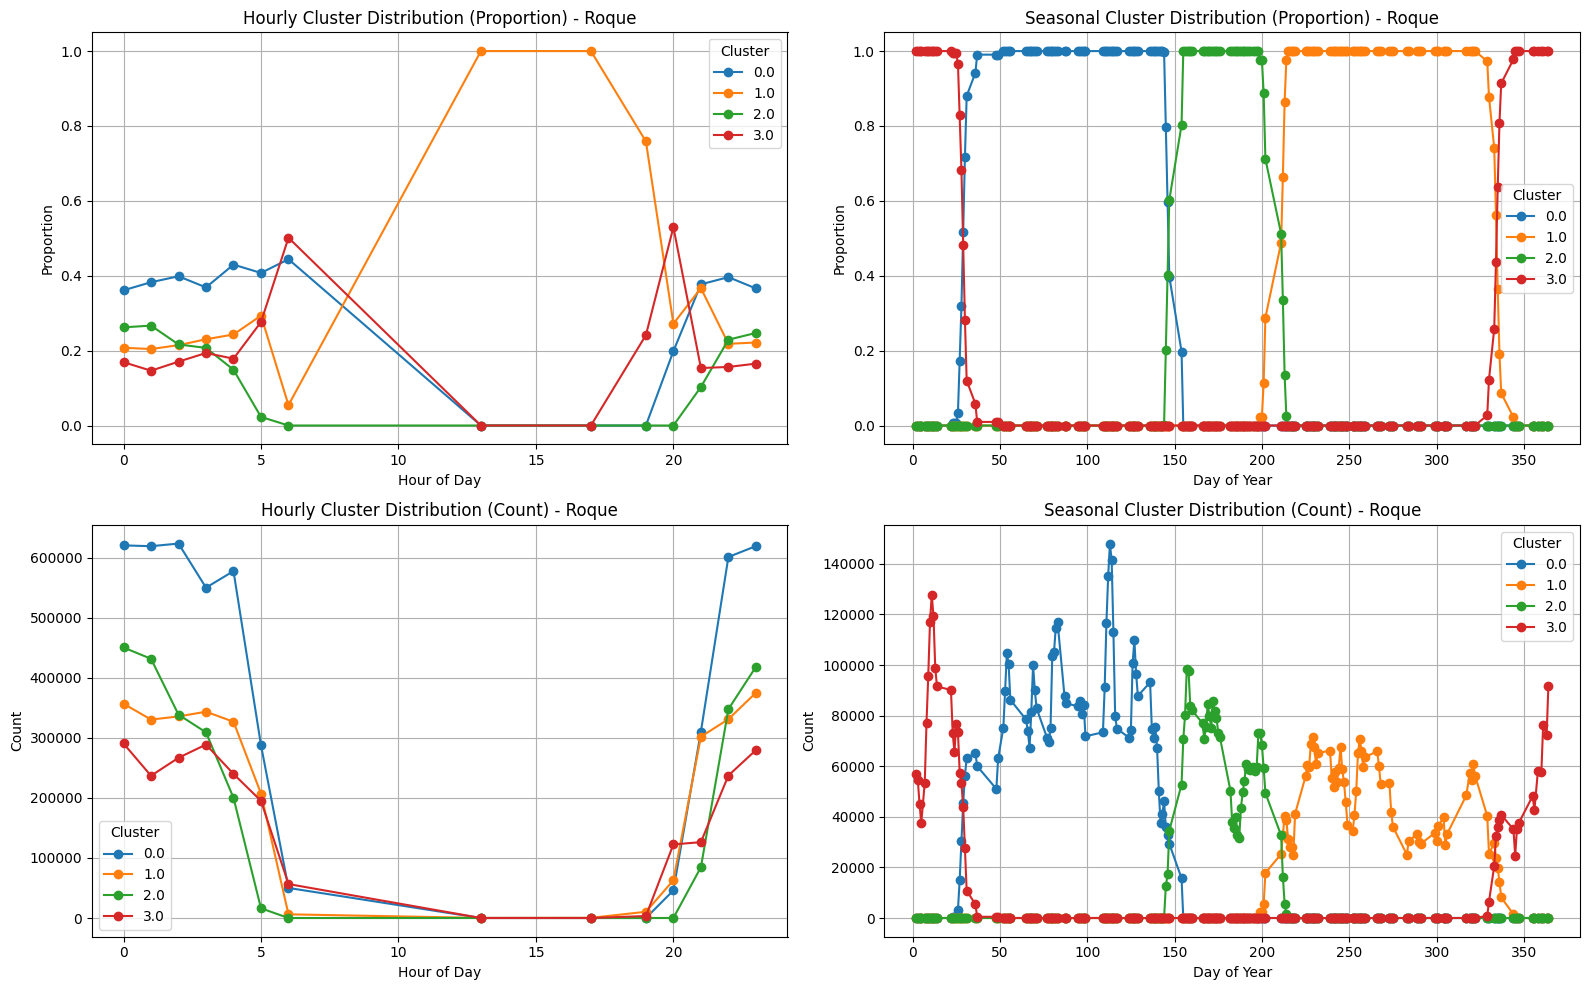

In [14]:
plot_cluster_temporal_distribution(df_teide, site_name="Teide")
plot_cluster_temporal_distribution(df_roque, site_name="Roque")

In [15]:
def plot_mean_turbulence_per_cluster_altitude(df, site_name="Site"):
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Compute average turbulence per cluster and altitude
    pivot = df.groupby(['altitude', 'cluster'])['turbulence_log'].mean().unstack()

    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot, cmap='cividis_r', cbar_kws={'label': 'Mean Turbulence (log)'}, annot=False)
    
    plt.title(f'Average Turbulence per Altitude and Cluster - {site_name}', fontsize=14)
    plt.xlabel('Cluster')
    plt.ylabel('Altitude (m)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

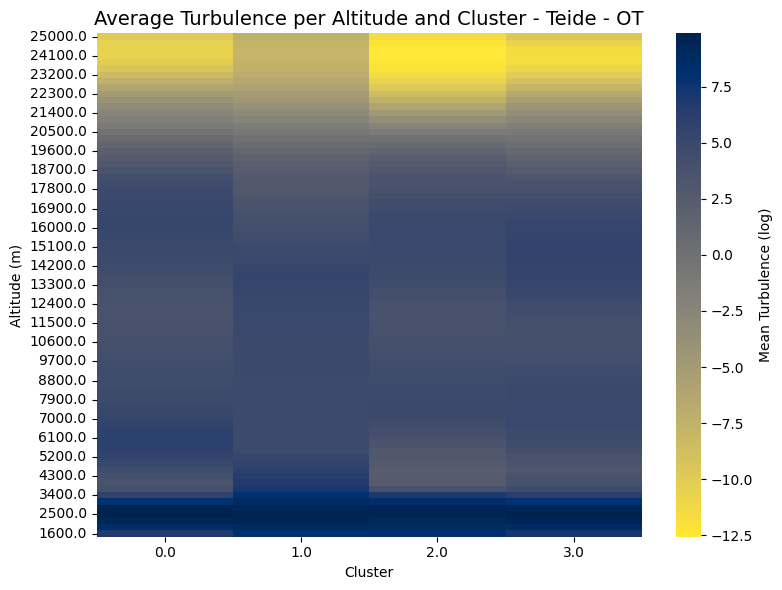

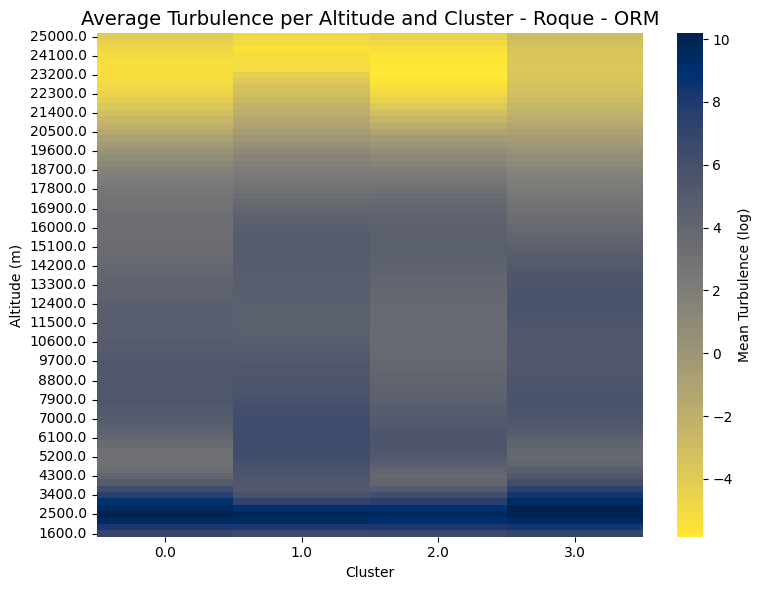

In [16]:
plot_mean_turbulence_per_cluster_altitude(df_teide, 'Teide - OT')
plot_mean_turbulence_per_cluster_altitude(df_roque, 'Roque - ORM')

In [17]:
def plot_best_cluster_summary(df, site_name="Site", normalize=True):
    """
    Plots the turbulence profile, seasonal dominance, and best hours for the cluster with the least turbulence.

    Parameters:
    - df: DataFrame with 'timestamp_begin', 'cluster', 'altitude', and 'turbulence_log'
    - site_name: str, name for plot titles
    - normalize: bool, whether to show proportions (True) or raw counts (False)
    """
    
    # Ensure timestamp column is datetime
    df['timestamp_begin'] = pd.to_datetime(df['timestamp_begin'])

    # Find the best cluster (cluster with the least mean turbulence across altitudes)
    profile_stats = df.groupby(['cluster', 'altitude'])['turbulence_log'].agg(['mean', 'std']).reset_index()

    # Find the cluster with the minimum mean turbulence
    best_cluster = profile_stats.groupby('cluster')['mean'].mean().idxmin()
    best_cluster_data = profile_stats[profile_stats['cluster'] == best_cluster]

    # Extract hour and day-of-year
    df['hour'] = df['timestamp_begin'].dt.hour
    df['dayofyear'] = df['timestamp_begin'].dt.dayofyear

    # Group by hour and seasonality (day-of-year)
    hourly = df[df['cluster'] == best_cluster].groupby(['hour', 'cluster']).size().unstack(fill_value=0)
    seasonal = df[df['cluster'] == best_cluster].groupby(['dayofyear', 'cluster']).size().unstack(fill_value=0)

    if normalize:
        hourly = hourly.div(hourly.sum(axis=1), axis=0)
        seasonal = seasonal.div(seasonal.sum(axis=1), axis=0)

    # --- Plotting ---
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Plot Turbulence Profile
    axs[0].plot(best_cluster_data['mean'], best_cluster_data['altitude'], label='Mean Profile', linewidth=2)
    axs[0].fill_betweenx(best_cluster_data['altitude'],
                         best_cluster_data['mean'] - best_cluster_data['std'],
                         best_cluster_data['mean'] + best_cluster_data['std'],
                         alpha=0.3, label='±1 std')
    axs[0].set_title(f'Turbulence Profile of Cluster {best_cluster} ({site_name})')
    axs[0].set_xlabel('Turbulence Value')
    axs[0].set_ylabel('Altitude (m)')
    axs[0].legend()
    axs[0].grid(True)

    # Plot Seasonal Distribution
    seasonal_smooth = seasonal.rolling(window=2, min_periods=1, center=True).mean()
    seasonal_smooth.plot(ax=axs[1], kind='line')
    axs[1].set_title(f'Seasonal Dominance of Cluster {best_cluster} ({site_name})')
    axs[1].set_xlabel('Day of Year')
    axs[1].set_ylabel('Proportion' if normalize else 'Count')
    axs[1].legend(title='Cluster')
    axs[1].grid(True)

    # Plot Hourly Distribution
    hourly.plot(ax=axs[2], kind='line', marker='o')
    axs[2].set_title(f'Best Hourly Turbulence for Cluster {best_cluster} ({site_name})')
    axs[2].set_xlabel('Hour of Day')
    axs[2].set_ylabel('Proportion' if normalize else 'Count')
    axs[2].legend(title='Cluster')
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()

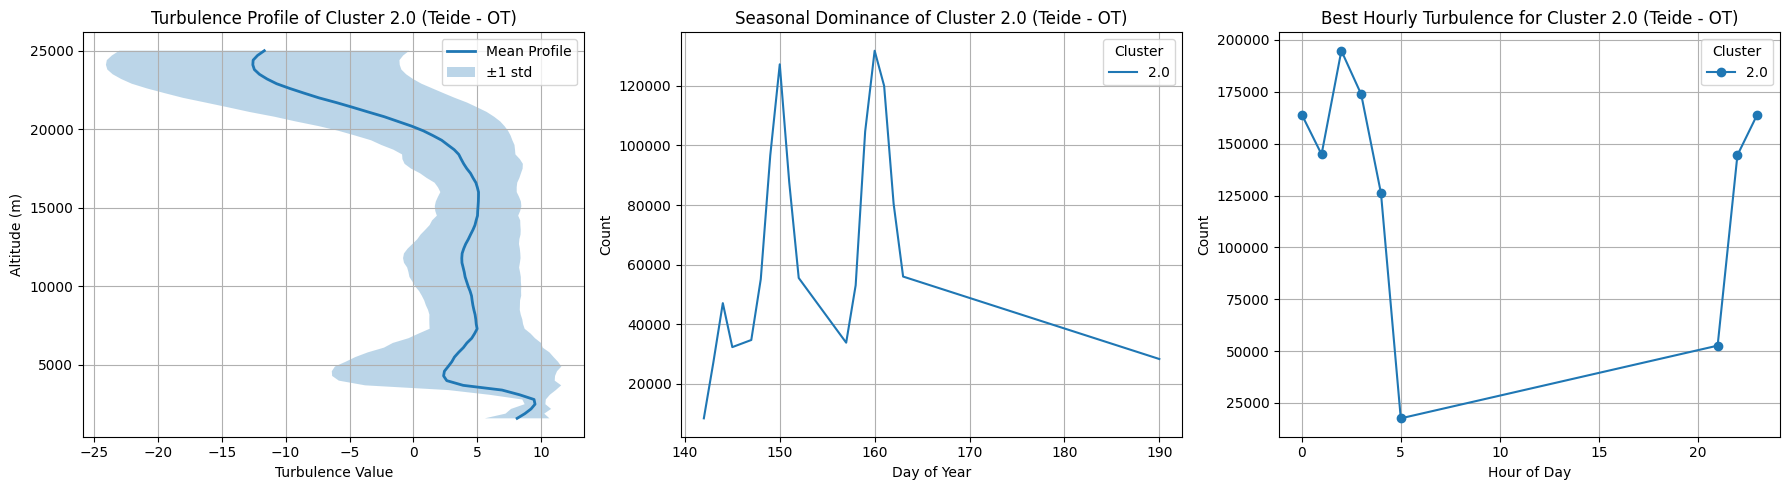

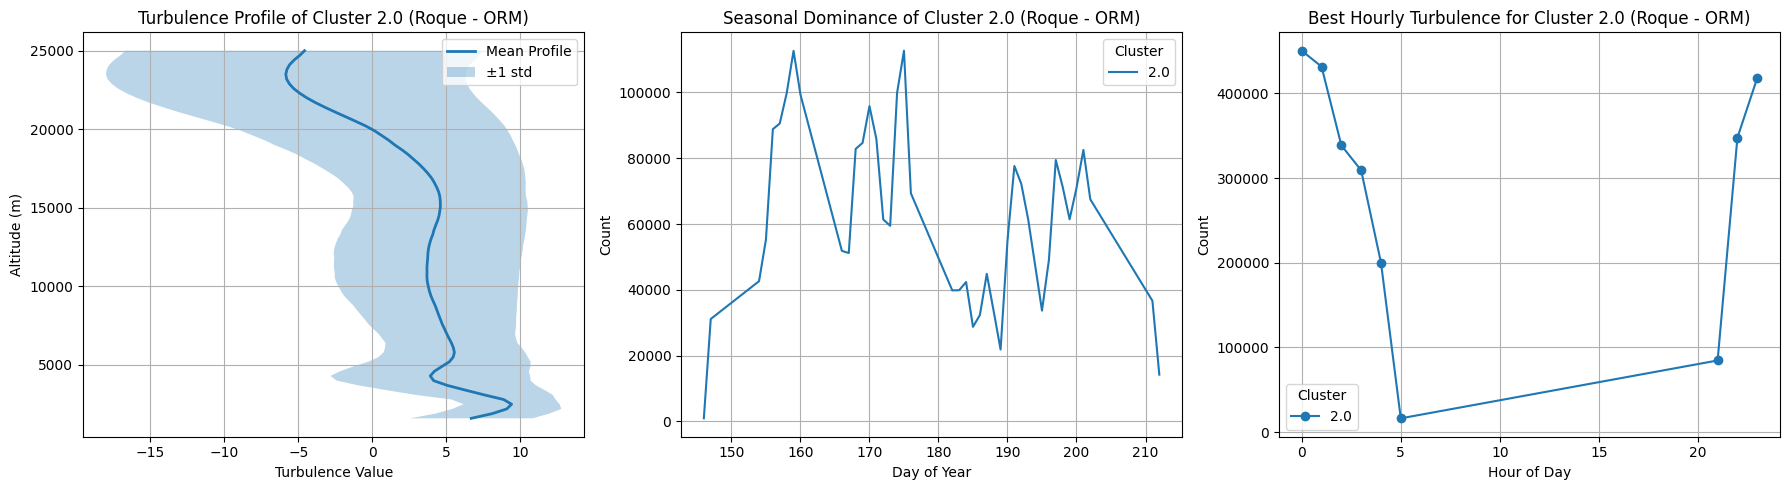

In [18]:
plot_best_cluster_summary(df_teide, 'Teide - OT',normalize=False)
plot_best_cluster_summary(df_roque, 'Roque - ORM',normalize=False)

In [19]:
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors

def plot_daily_altitude_turbulence_heatmap_interpolated(
    df, alt_col, turb_col, site_name="Site",
    agg_func=np.nanmedian, agg_label="Median",
    cmap='cividis_r', vmin=None, vmax=None,
    expected_alt_min=1600, expected_alt_max=25000, expected_alt_step=300,
    alt_unit="m",
    interpolate_days=False, # Flag to enable interpolation
    interp_method='linear', # Interpolation method
    interp_limit_days=5      # Max consecutive days to fill
):
    """
    Plots a heatmap showing daily aggregated turbulence, with optional interpolation
    for missing days.

    Parameters:
    - df: DataFrame with the data.
    - alt_col: str, column name for altitude.
    - turb_col: str, column name for the turbulence metric.
    - site_name: str, name for plot titles.
    - agg_func: function, aggregation function (e.g., np.nanmedian).
    - agg_label: str, label for the aggregation (e.g., "Median").
    - cmap: str or Colormap, colormap for the heatmap.
    - vmin, vmax: float or None, fixed color scale limits.
    - expected_alt_min, expected_alt_max, expected_alt_step: float,
        Define the expected regular altitude range and step.
    - alt_unit: str, Unit of altitude for y-axis label.
    - interpolate_days: bool, If True, interpolate missing daily values.
    - interp_method: str, Method for interpolation (passed to pandas.interpolate).
                     Examples: 'linear', 'time', 'quadratic', 'cubic'.
    - interp_limit_days: int or None, Maximum number of consecutive days to
                         interpolate over. If None, no limit.
    """
    # --- 1. Data Preparation ---
    # ... (copy, checks, datetime, numeric conversion, dropna) ...
    df_plot = df.copy()
    if alt_col not in df_plot.columns: print(f"Error: Altitude column '{alt_col}' not found."); return
    if turb_col not in df_plot.columns: print(f"Error: Turbulence column '{turb_col}' not found."); return
    if 'timestamp_begin' not in df_plot.columns: print("Error: Must contain 'timestamp_begin'."); return

    try:
        df_plot['timestamp_begin'] = pd.to_datetime(df_plot['timestamp_begin'])
        df_plot['date'] = df_plot['timestamp_begin'].dt.floor('D')
    except Exception as e: print(f"Error processing 'timestamp_begin': {e}"); return

    df_plot[alt_col] = pd.to_numeric(df_plot[alt_col], errors='coerce')
    df_plot[turb_col] = pd.to_numeric(df_plot[turb_col], errors='coerce')
    df_plot.dropna(subset=['date', alt_col, turb_col], inplace=True)
    if df_plot.empty: print(f"No valid data remaining after cleaning NaNs."); return

    # --- 2. Aggregation & Pivoting ---
    # ... (groupby, agg, unstack/pivot) ...
    daily_agg = df_plot.groupby(['date', alt_col])[turb_col].agg(agg_func)
    try:
        daily_agg_pivot = daily_agg.unstack(level=alt_col)
    except Exception as e:
         print(f"Error unstacking data: {e}. Attempting pivot fallback...")
         try:
             daily_agg_reset = daily_agg.reset_index()
             daily_agg_pivot = daily_agg_reset.pivot(index='date', columns=alt_col, values=turb_col)
         except Exception as e2: print(f"Fallback pivot also failed: {e2}"); return

    if daily_agg_pivot.empty: print("Pivoted table is empty."); return

    # --- 3. Handle Time Gaps & Sort Altitudes ---
    # ... (create full date range, reindex, sort columns) ...
    full_date_range = pd.date_range(start=daily_agg_pivot.index.min(),
                                    end=daily_agg_pivot.index.max(), freq='D')
    daily_agg_pivot = daily_agg_pivot.reindex(full_date_range)
    daily_agg_pivot = daily_agg_pivot.sort_index(axis=1) # Sort altitudes numerically

    # --- 3b. Interpolation (New Step) ---
    interp_title_part = "" # Initialize title addition
    if interpolate_days:
        if not daily_agg_pivot.empty:
            print(f"Interpolating missing days (method='{interp_method}', limit={interp_limit_days} days)...")
            # Interpolate along the time axis (axis=0) for each altitude column
            try:
                daily_agg_pivot = daily_agg_pivot.interpolate(
                    method=interp_method,
                    axis=0,
                    limit=interp_limit_days,
                    limit_direction='forward', # Fill forwards up to limit
                    limit_area=None           # Fill anywhere (not just inside gaps)
                )
                print("Interpolation complete.")
                interp_title_part = f" (Interpolated, limit={interp_limit_days} days)"
            except Exception as e:
                print(f"Warning: Interpolation failed. Error: {e}")
        else:
            print("Skipping interpolation as data is empty.")

    # --- 4. Plotting ---
    # ... (Plotting setup: fig, ax, dates, altitudes, transpose data) ...
    fig, ax = plt.subplots(figsize=(18, 8))
    dates = daily_agg_pivot.index
    altitudes = daily_agg_pivot.columns.to_numpy(dtype=float)
    turbulence_data = daily_agg_pivot.values.T # Transpose for pcolormesh

    # --- Edge Calculation ---
    date_edges = mdates.date2num(dates)
    delta_dates = np.diff(date_edges)
    if len(delta_dates) == 0: delta_dates = np.array([1.0])
    date_edges = np.concatenate(([date_edges[0] - delta_dates[0]/2],
                                 date_edges[:-1] + delta_dates/2,
                                 [date_edges[-1] + delta_dates[-1]/2]))

    if len(altitudes) > 0:
      alt_step = expected_alt_step
      alt_edges = np.arange(altitudes.min() - alt_step/2, altitudes.max() + alt_step/2 + alt_step, alt_step)
      if len(alt_edges) != len(altitudes) + 1:
            print("Warning: Calculated altitude edges don't match data dimension. Falling back.")
            delta_alts = np.diff(altitudes, append=altitudes[-1] + np.diff(altitudes)[-1] if len(altitudes)>1 else alt_step)
            alt_edges = np.concatenate(([altitudes[0] - delta_alts[0]/2], altitudes + delta_alts/2))
    elif len(altitudes) == 1:
        alt_step = expected_alt_step
        alt_edges = np.array([altitudes[0] - alt_step/2, altitudes[0] + alt_step/2])
    else: alt_edges = np.array([0, 1])

    # --- Create the plot (using potentially interpolated data) ---
    mesh = ax.pcolormesh(date_edges, alt_edges, turbulence_data,
                         cmap=cmap, vmin=vmin, vmax=vmax, shading='flat')

    # --- Colorbar and Labels (add interpolation info to title) ---
    cbar = fig.colorbar(mesh, ax=ax, pad=0.01, aspect=30)
    cbar.set_label(f"{agg_label} {turb_col}")
    ax.set_title(f"Daily {agg_label} {turb_col} vs Altitude - {site_name}{interp_title_part}") # Add note
    ax.set_xlabel("Date")
    ax.set_ylabel(f"{alt_col} ({alt_unit})")

    # --- Axis Formatting (two-tier date labels, months and years) ---
    # Y-axis (Altitudes)
    ax.set_ylim(expected_alt_min - expected_alt_step, expected_alt_max + expected_alt_step)
    major_ticks_y = np.arange(2000, expected_alt_max + 1, 4000) # Ticks every 4000m
    minor_ticks_y = np.arange(expected_alt_min, expected_alt_max + 1, 1000) # Ticks every 1000m
    ax.yaxis.set_major_locator(mticker.FixedLocator(major_ticks_y))
    ax.yaxis.set_minor_locator(mticker.FixedLocator(minor_ticks_y))
    ax.tick_params(axis='y', which='minor', length=3, direction='in') # Minor ticks inwards
    ax.tick_params(axis='y', which='major', length=6, direction='in') # Major ticks inwards

    # --- X-axis (Dates) ---
    # Minor ticks: Months (e.g., every X months, interval)
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1)) # Show tick every 1 months
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b')) # Format as 'Jan', 'Feb', etc.

    # Major ticks: Years (at the start of each year)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # Format as '2022', '2023'

    # --- Styling the ticks for two tiers ---
    # Style Minor Ticks (Months)
    ax.tick_params(axis='x', which='minor', length=4, labelsize=9) # Adjust length/size
    plt.setp(ax.get_xminorticklabels(), rotation=90, ha='center') # Rotate months if needed

    # Style Major Ticks (Years) - Push them down using 'pad'
    # Increase padding significantly to create space below months
    ax.tick_params(axis='x', which='major', length=0, labelsize=11, pad=25) # No tick line, push label down

    # Grid lines based on minor ticks (months) if desired
    ax.grid(True, axis='x', which='minor', linestyle=':', linewidth=0.5, alpha=0.7)
    ax.grid(False, axis='x', which='major') # Turn off grid lines for the year ticks

    plt.tight_layout()
    plt.show()


--- Plotting with Interpolation ---


/var/folders/gl/j8qjwyrs4j7clsv687ktgxtr0000gn/T/ipykernel_3918/3389343571.py:56: FutureWarning: The provided callable <function nanmedian at 0x1096fc360> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  daily_agg = df_plot.groupby(['date', alt_col])[turb_col].agg(agg_func)


Interpolating missing days (method='linear', limit=20 days)...
Interpolation complete.


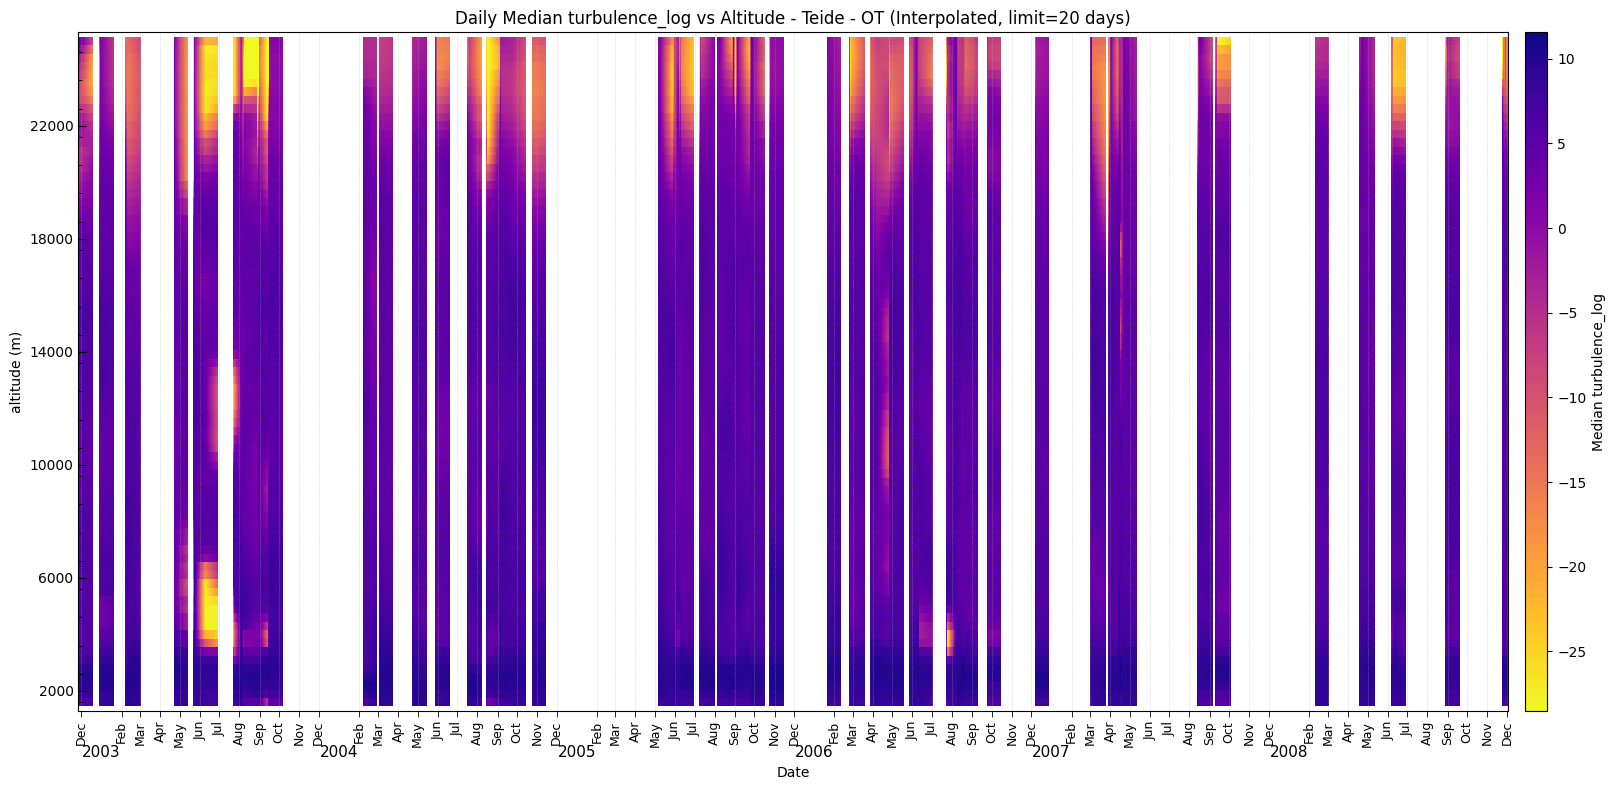


--- Plotting without Interpolation (for comparison) ---


/var/folders/gl/j8qjwyrs4j7clsv687ktgxtr0000gn/T/ipykernel_3918/3389343571.py:56: FutureWarning: The provided callable <function nanmedian at 0x1096fc360> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  daily_agg = df_plot.groupby(['date', alt_col])[turb_col].agg(agg_func)


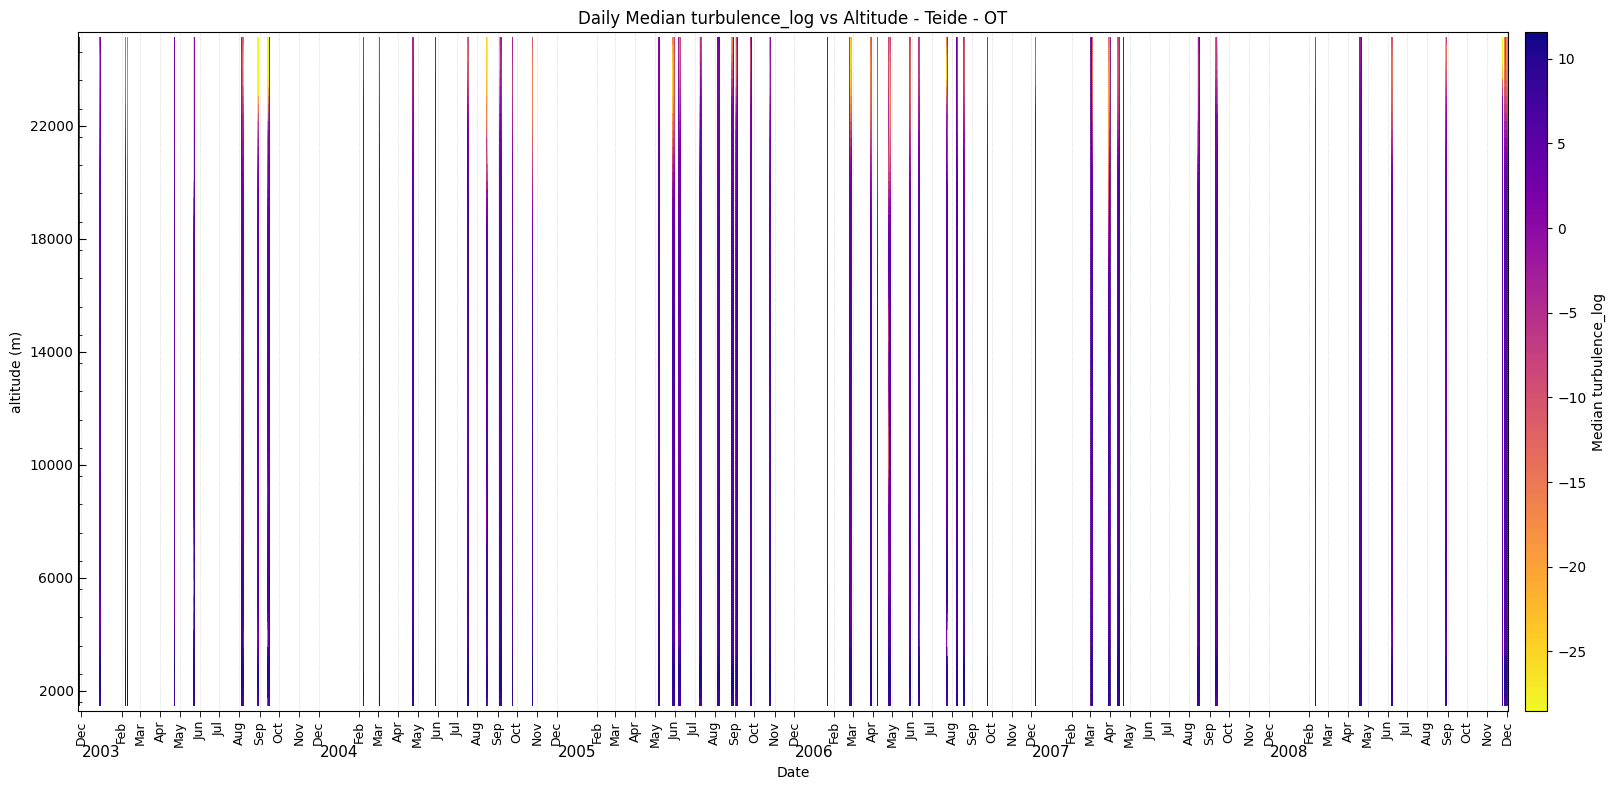

In [20]:
#Call the the previous funciton for both observatories, there are a lot of params that we can use when calling it.
#For comparison I am calling the function for OT with and without interpolation
print("\n--- Plotting with Interpolation ---")

# Call the function with interpolation enabled
plot_daily_altitude_turbulence_heatmap_interpolated(
    df_teide,
    alt_col='altitude',
    turb_col='turbulence_log',
    site_name="Teide - OT",
    agg_func=np.nanmedian,
    agg_label="Median",
    cmap='plasma_r',
    expected_alt_min=1600,
    expected_alt_max=25000,
    expected_alt_step=300,
    alt_unit="m",
    interpolate_days=True,      # <<< Turn interpolation ON
    interp_method='linear',     # <<< Use linear method
    interp_limit_days=20         # <<< Fill gaps up to 7 consecutive days
)

print("\n--- Plotting without Interpolation (for comparison) ---")

# Call the function without interpolation
plot_daily_altitude_turbulence_heatmap_interpolated(
    df_teide,
    alt_col='altitude',
    turb_col='turbulence_log',
    site_name="Teide - OT",
    agg_func=np.nanmedian,
    agg_label="Median",
    cmap='plasma_r', # Use same cmap for comparison
    expected_alt_min=1600,
    expected_alt_max=25000,
    expected_alt_step=300,
    alt_unit="m",
    interpolate_days=False     # <<< Turn interpolation OFF
)


--- Plotting with Interpolation ---


/var/folders/gl/j8qjwyrs4j7clsv687ktgxtr0000gn/T/ipykernel_3918/3389343571.py:56: FutureWarning: The provided callable <function nanmedian at 0x1096fc360> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  daily_agg = df_plot.groupby(['date', alt_col])[turb_col].agg(agg_func)


Interpolating missing days (method='linear', limit=20 days)...
Interpolation complete.


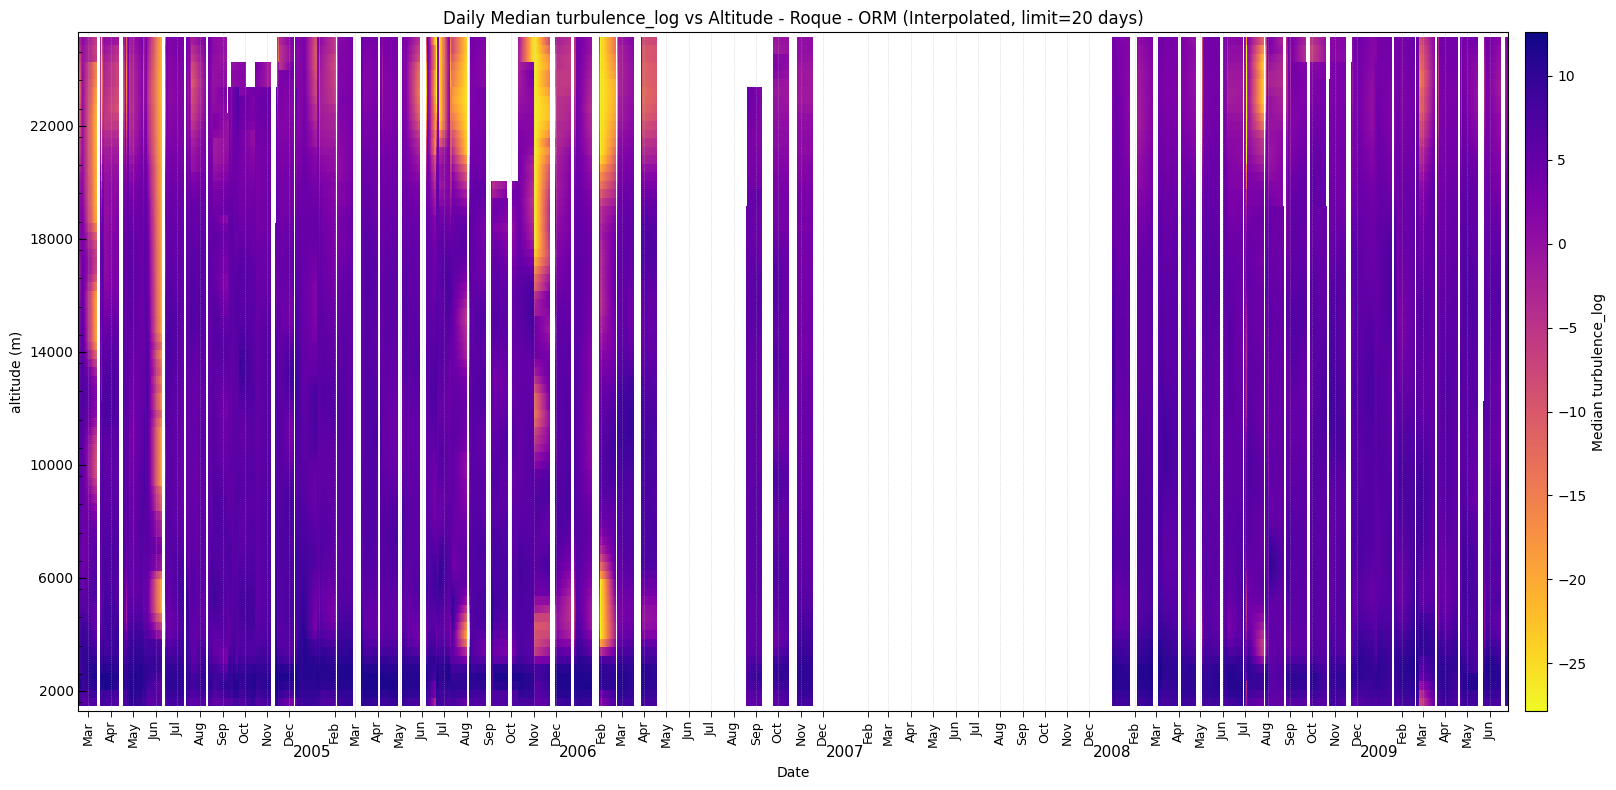


--- Plotting without Interpolation (for comparison) ---


/var/folders/gl/j8qjwyrs4j7clsv687ktgxtr0000gn/T/ipykernel_3918/3389343571.py:56: FutureWarning: The provided callable <function nanmedian at 0x1096fc360> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  daily_agg = df_plot.groupby(['date', alt_col])[turb_col].agg(agg_func)


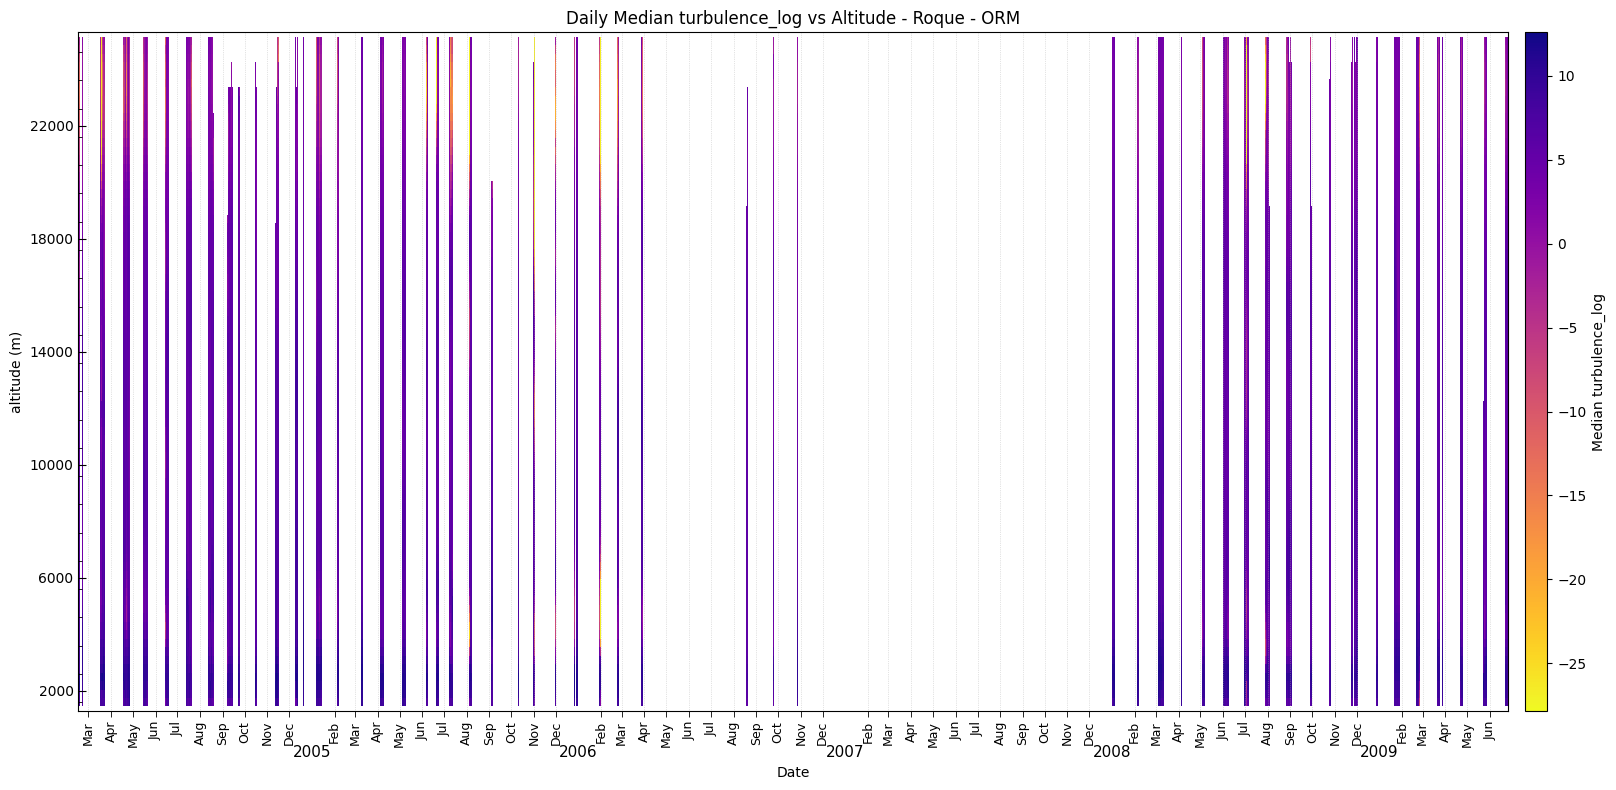

In [21]:
#Same but for Roque
print("\n--- Plotting with Interpolation ---")

# Call the function with interpolation enabled
plot_daily_altitude_turbulence_heatmap_interpolated(
    df_roque,
    alt_col='altitude',
    turb_col='turbulence_log',
    site_name="Roque - ORM",
    agg_func=np.nanmedian,
    agg_label="Median",
    cmap='plasma_r',
    expected_alt_min=1600,
    expected_alt_max=25000,
    expected_alt_step=300,
    alt_unit="m",
    interpolate_days=True,      # <<< Turn interpolation ON
    interp_method='linear',     # <<< Use linear method
    interp_limit_days=20         # <<< Fill gaps up to 7 consecutive days
)

print("\n--- Plotting without Interpolation (for comparison) ---")

# Call the function without interpolation
plot_daily_altitude_turbulence_heatmap_interpolated(
    df_roque,
    alt_col='altitude',
    turb_col='turbulence_log',
    site_name="Roque - ORM",
    agg_func=np.nanmedian,
    agg_label="Median",
    cmap='plasma_r', # Use same cmap for comparison
    expected_alt_min=1600,
    expected_alt_max=25000,
    expected_alt_step=300,
    alt_unit="m",
    interpolate_days=False     # <<< Turn interpolation OFF
)